In [1]:
import numpy as np
from noise import pnoise3 
from skimage.draw import line_nd
from scipy.ndimage import binary_dilation
from skimage.morphology import skeletonize
from scipy import ndimage
from skimage.morphology import ball
import numpy as np
from scipy.ndimage import label
import time
import os
from scipy.ndimage import find_objects
from scipy.stats import rankdata
import bisect

import numpy as np
from scipy.ndimage import label, find_objects

import numpy as np
from scipy.ndimage import label, binary_dilation, generate_binary_structure
import random

from collections import defaultdict
from scipy.ndimage import label, convolve, find_objects


In [ ]:
import numpy as np
from multiprocessing import Pool, cpu_count
from noise import pnoise3, pnoise1
from skimage.morphology import skeletonize
from scipy import ndimage
from skimage.morphology import ball
import numpy as np
import time
import os
from scipy.ndimage import find_objects
from scipy.stats import rankdata, rv_discrete
import bisect
import random
from skimage.draw import line_nd
from scipy.ndimage import label, binary_dilation, generate_binary_structure,find_objects
from collections import defaultdict


class ArtificialSkeletonGenerator:
    """Class to generate 3D artificial skeleton datasets with wobbly line patterns."""

    def __init__(self, shape=(128, 128, 128)):
        self.shape = shape  # Define the shape of the 3D volume
        

        self.wobble_strengths = [7.0, 4.0, 1.0]
        self.wobble_scales = [0.03, 0.06, 0.09]

        self.wobble_strengths = [x * 1.5 for x in self.wobble_strengths]
        self.wobble_scales = [x * 1.5 for x in self.wobble_scales]

    def get_random_border_start(self):
        """Returns a random start point along the top (y=max) or left (z=0) border."""
        side = np.random.choice(["y=max", "z=0"])
        if side == "y=max":
            return np.random.randint(0, self.shape[0]), self.shape[1] - 1, np.random.randint(0, self.shape[2])
        else:
            return np.random.randint(0, self.shape[0]), np.random.randint(0, self.shape[1]), 0

    def connect_voxels(self, start, end,  art_data):
        """Ensures connectivity between discrete points by interpolating."""
        rr, cc, zz = line_nd(start, end)
        art_data[rr, cc, zz] = 1
        return rr, cc, zz

    def calculate_radius(self, center, start):
        """Calculate the radius of the circle given a center and a start point."""
        return np.sqrt((start[0] - center[0]) ** 2 + (start[1] - center[1]) ** 2)

    def get_next_point(self, center, current, step_size, clockwise=True):
        """Find the next point moving around the circle."""
        # debug by just printing the current point and add a small offset
        # return current + np.array([-1, 1])

        radius = self.calculate_radius(center, current)
        angle = np.arctan2(current[1] - center[1], current[0] - center[0])
        angle += -step_size if clockwise else step_size
        new_x = center[0] + radius * np.cos(angle)
        new_y = center[1] + radius * np.sin(angle)
        
        return (new_x, new_y)

    def size_distribution(self):
        loaded_data = np.load("component_sizes.npy")

        # Split into unique_sizes and counts
        unique_sizes, counts = loaded_data[:, 0], loaded_data[:, 1]
        probabilities = counts / counts.sum()  # Normalize to create probabilities

        # Define a discrete random variable based on observed sizes
        size_distribution = rv_discrete(name="component_size_dist", values=(unique_sizes, probabilities))
        return size_distribution

    def generate_skeleton_data(self, num_lines):
        """Generates a 3D artificial dataset with wobbly skeleton structures."""
        start_time = time.time()
        p_noise_time = 0
        connect_voxels_time = 0
        clip_time = 0
        get_next_point_time = 0
        art_data = np.zeros(self.shape, dtype=np.uint8)  # Initialize empty dataset
        skeletons = []  # Store the generated skeletons

        mod_size = num_lines//100
        for i in range(num_lines):
            x, y, z = self.get_random_border_start()
            seed_x, seed_yz = np.random.randint(0, 100000, size=2)
            noise_step, prev_x, prev_y, prev_z = 0, x, y, z
            line_length = np.max(self.shape)*2  
            line_index = 0

            center = ((self.shape[1]-1)*3, (self.shape[2]-1)*2.4)
            start = (y, z)
            clockwise = True
            radius = self.calculate_radius(center, start)
            num_steps = int(2 * np.pi * radius) * 0.25
            step_size = 2 * np.pi / num_steps
            next_point = start
            line_indices = []

            while 0 <= y < self.shape[1] and 0 <= z < self.shape[2] and line_index < line_length:
                line_index += 1
                total_dx, total_dy, total_dz = 0, 0, 0
                for strength, scale in zip(self.wobble_strengths, self.wobble_scales):
                    p_noise_start = time.time()
                    noise_x = pnoise1((noise_step + seed_x) * scale) * strength
                    noise_yz = pnoise1((noise_step + seed_yz) * scale) * strength
                    p_noise_time += time.time() - p_noise_start
                    total_dx += noise_x / np.sqrt(2)
                    total_dy += noise_yz / np.sqrt(2)
                    total_dz += noise_yz / np.sqrt(2)

                dx, dy, dz = int(total_dx), int(total_dy), int(total_dz)

                get_next_point_start = time.time()
                next_point = self.get_next_point(center, next_point, step_size, clockwise)
                get_next_point_time += time.time() - get_next_point_start
                y, z = int(next_point[0]), int(next_point[1])

                clip_start = time.time()
                y_set = np.clip(y + dy, 0, self.shape[1] - 1)
                z_set = np.clip(z + dz, 0, self.shape[2] - 1)
                x_set = np.clip(x + dx, 0, self.shape[0] - 1)
                clip_time += time.time() - clip_start

                

                if 0 <= y_set < self.shape[1]:
                    if (x_set, y_set, z_set) != (prev_x, prev_y, prev_z):
                        connect_voxels_start = time.time()
                        rr, cc, zz = self.connect_voxels((prev_x, prev_y, prev_z), (x_set, y_set, z_set),art_data)
                        connect_voxels_time += time.time() - connect_voxels_start
                        for r, c, z in zip(rr, cc, zz):
                            line_indices.append((r, c, z))

                    art_data[x_set, y_set, z_set] = 1
                    line_indices.append((x_set, y_set, z_set))
                    prev_x, prev_y, prev_z = x_set, y_set, z_set

                    if (z_set >= self.shape[2] - 1):
                        break  # Stop the line from moving further
                else:
                    break

                noise_step += 1

            skeletons.append(line_indices)

        return art_data, skeletons


class ArtificialSkeletonGeneratorExtended(ArtificialSkeletonGenerator):
    """Extended class that can generate skeletons and also break them into segments."""

    def break_skeletons(self, full_skeleton, skeletons, gap_threshold = 10, gap_min=1, gap_chance=0.3):
        """
        Breaks skeletons into smaller disconnected parts using a size distribution.
        Inserts gaps between them (some large, some small).

        Returns:
            skeletons_splitted: volume with retained skeleton segments
            small_hole_skeleton: volume with small gaps (1–10)
            large_hole_skeleton: volume with large gaps (30–50)
        """
        size_distribution = self.size_distribution()

        splits, small_gaps, large_gaps, n_small = self.split_skeletons(skeletons, size_distribution, gap_chance, gap_threshold, gap_min=gap_min)

        shape = self.shape
        skeletons_splitted = np.zeros(shape, dtype=np.uint8)
        small_hole_skeleton = np.zeros(shape, dtype=np.uint8)
        large_hole_skeleton = np.zeros(shape, dtype=np.uint8)

        for split in splits:
            for x, y, z in split:
                skeletons_splitted[x, y, z] = 1

        for gap in small_gaps:
            for x, y, z in gap:
                small_hole_skeleton[x, y, z] = 1

        for gap in large_gaps:
            for x, y, z in gap:
                large_hole_skeleton[x, y, z] = 1


        # scatter n_small random points in the skeletons_splitted
        print (f"Number of small holes: {n_small}")
        for _ in range(n_small[0]):
            x = np.random.randint(0, shape[0])
            y = np.random.randint(0, shape[1])
            z = np.random.randint(0, shape[2])
            skeletons_splitted[x, y, z] = 1
        for _ in range(n_small[1]):
            # do the same just add two points next to each other
            x = np.random.randint(0, shape[0])
            y = np.random.randint(0, shape[1])
            z = np.random.randint(0, shape[2])
            skeletons_splitted[x, y, z] = 1
            # random 3d offset
            x2 = np.clip(x + np.random.randint(-1, 2), 0, shape[0]-1)
            y2 = np.clip(y + np.random.randint(-1, 2), 0, shape[1]-1)
            z2 = np.clip(z + np.random.randint(-1, 2), 0, shape[2]-1)
            skeletons_splitted[x2, y2, z2] = 1

        for _ in range(n_small[2]):
            # do the same just add two points next to each other
            x = np.random.randint(0, shape[0])
            y = np.random.randint(0, shape[1])
            z = np.random.randint(0, shape[2])
            skeletons_splitted[x, y, z] = 1
            # random 3d offset
            x2 = np.clip(x + np.random.randint(-1, 2), 0, shape[0]-1)
            y2 = np.clip(y + np.random.randint(-1, 2), 0, shape[1]-1)
            z2 = np.clip(z + np.random.randint(-1, 2), 0, shape[2]-1)
            skeletons_splitted[x2, y2, z2] = 1
            # random 3d offset
            x3 = np.clip(x + np.random.randint(-1, 2), 0, shape[0]-1)
            y3 = np.clip(y + np.random.randint(-1, 2), 0, shape[1]-1)
            z3 = np.clip(z + np.random.randint(-1, 2), 0, shape[2]-1)
            skeletons_splitted[x3, y3, z3] = 1




        print (f"skeletons_splitted unique: {np.unique(skeletons_splitted)}")
        return skeletons_splitted, small_hole_skeleton, large_hole_skeleton


    def split_skeletons(self, skeletons, size_distribution, large_gap_chance=0.3, gap_threshold=10, gap_min=1):
        splits = []
        small_gaps = []
        large_gaps = []

        n_small = [0, 0, 0]

        for skel in skeletons:
            i = 0
            fail_count = 0

            # Pre-sample initial split size
            split_size = size_distribution.rvs(size=1)[0]

            while i < len(skel) and fail_count < 5:
                # Skip tiny segments sometimes
                if split_size <= 3 and random.random() < 0.5:
                    n_small[split_size - 1] += 1
                    split_size = size_distribution.rvs(size=1)[0]
                    continue

                # Sample gap
                if random.random() < large_gap_chance:
                    gap_size = random.randint(gap_threshold, 50)
                    is_large = True
                else:
                    gap_size = random.randint(gap_min, gap_threshold)
                    is_large = False

                # Sample the NEXT split size in advance
                next_split_size = size_distribution.rvs(size=1)[0]

                total_needed = split_size + gap_size + next_split_size
                if i + total_needed >= len(skel):
                    fail_count += 1
                    break

                # Add current split
                split = skel[i:i + split_size]
                splits.append(split)
                i += split_size

                # Add gap
                gap = skel[i:i + gap_size]
                (large_gaps if is_large else small_gaps).append(gap)
                i += gap_size

                # Prepare for next loop
                split_size = next_split_size
                fail_count = 0  # reset fail count

        return splits, small_gaps, large_gaps, n_small





    def draw_splits_to_array(self, splits):
        """
        Creates a new array where selected indices from the splits are marked.

        Args:
            shape (tuple): Shape of the output array.
            splits (list of lists): Each list contains (x, y, z) indices to be marked.

        Returns:
            np.ndarray: New array with marked indices.
        """
        new_array = np.zeros(self.shape, dtype=np.uint8)

        label = 1
        for split in splits:
            for x, y, z in split:
                new_array[x, y, z] = label
            label += 1  

        return new_array, label

    def generate_broken_skeleton_data(self, num_lines=15, max_gap=20, gap_threshold=10, gap_min=1, gap_chance=0.3, thickness=0, save_full_skeleton=False):
        """
        Generates both the full skeleton data and a broken version.

        Args:
            total_sum (int): The total number of voxels to include in the broken skeleton.

        Returns:
            tuple: (full skeleton, broken skeleton)
        """
        # Generate full skeleton first
        start_time = time.time()
        full_skeleton, skeletons = self.generate_skeleton_data(num_lines=num_lines)
        #print(f"Generated full skeleton in {time.time() - start_time:.2f} seconds.")
        start_time = time.time()
        #print(f"Removed close by dilation in {time.time() - start_time:.2f} seconds.")
        start_time = time.time()

        if save_full_skeleton:
            # Define the folder path
            file_path = "FullSkeletonData"

            # Ensure the directory exists
            os.makedirs(file_path, exist_ok=True)

            # Save the full skeleton to a file
            np.save(os.path.join(file_path, "full_skeleton.npy"), full_skeleton)

            #print(f"Saved full skeleton to {file_path}/full_skeleton.npy")
        
        # Generate the broken skeleton
        skeletons_splitted, small_hole_skeleton, large_hole_skeleton = self.break_skeletons(full_skeleton.copy(), skeletons, gap_threshold = gap_threshold, gap_min=gap_min, gap_chance=gap_chance)#, total_sum=total_sum) # We gonna make break_skeletons return like label.

        hole_skeleton = small_hole_skeleton.copy()
        # broken_skeleton = full_skeleton.copy()
        # broken_skeleton[hole_skeleton > 0] = 0

        # skeletons_splitted_new = self.remove_close_by_dilation(skeletons_splitted, hole_skeleton, dilation_radius=1)
        # skeletons_splitted = skeletons_splitted_new
        
        # hole_skeleton = full_skeleton.copy() 
        # hole_skeleton[skeletons_splitted == 1] = 0

        # hole_addtion = self.find_short_skeletons_as_holes(skeletons_splitted, hole_skeleton)
        # hole_skeleton = hole_skeleton + hole_addtion


        #print(f"Generated broken skeleton in {time.time() - start_time:.2f} seconds.")
        start_time = time.time()

        start_time = time.time()
        # hole_skeleton = self.remove_skeleton_under_length(hole_skeleton, max_gap)
        # #print(f"Removed under lenght holes in {time.time() - start_time:.2f} seconds.")
        start_time = time.time()


        if (thickness >= 1):
            hole_skeleton = self.spherical_dilation(hole_skeleton, radius=thickness)

        #print (f"Time taken for dilation: {time.time()-start_time}")



        return skeletons_splitted, hole_skeleton, large_hole_skeleton
    
    def spherical_dilation(self, volume, radius):
        # Create the spherical (ball) structuring element
        struct_elem = ball(radius)

        # Perform binary dilation
        dilated_volume = binary_dilation(volume, structure=struct_elem)

        return dilated_volume.astype(np.uint8)
    
    def create_float_ball(self, radius, size = None):
        if size is None:
            size = int(np.ceil(radius * 2)) + 1
        center = (np.array([size, size, size]) - 1) / 2
        zz, yy, xx = np.indices((size, size, size))
        distance = np.sqrt((xx - center[0])**2 + (yy - center[1])**2 + (zz - center[2])**2)
        ball = (distance <= radius).astype(np.uint8)
        return ball


    def variable_spherical_dilation(self, volume, noise_scale=0.1):
        start_time = time.time()

        # Label connected skeletons
        labeled_volume, num_features = label(volume, structure=np.ones((3, 3, 3)))
        label_time = time.time() - start_time

        # Precompute slices for each skeleton
        slices = find_objects(labeled_volume)

        dilated_volume = np.zeros_like(volume)
        grid_shape = volume.shape

        perlin_noise_time = 0
        argwhere_time = 0
        boundary_check_time = 0
        dilation_time = 0
        interp_time = 0
        ball_time = 0

        #print(f"Setup time: {label_time}, number of slices: {len(slices)}")

        mod_size = max(num_features // 100, 1)

        # Sort the width distribution once for efficient lookup
        widths = np.array([2.0, 2.82842712, 3.46410162, 4.0, 4.47213595, 4.89897949])
        size = 6
        balls = [self.create_float_ball(r/2, size) for r in widths]
        # Precompute CDF once at the top
        counts = np.array([51964, 48412, 27655, 11158, 6832, 134])
        probabilities = counts / counts.sum()
        cdf = np.cumsum(probabilities)

        # === Precompute Perlin noise empirical CDF mapping ===
        #print("Precomputing Perlin noise CDF...")
        perlin_samples = 10000
        perlin_noise_samples = np.array([pnoise3(i * noise_scale, i * noise_scale, i * noise_scale) for i in range(perlin_samples)])
        perlin_noise_normalized = (perlin_noise_samples + 1) / 2  # [0, 1]
        # Rank-based mapping
        ranks = rankdata(perlin_noise_normalized, method="average")
        perlin_cdf_map = ranks / perlin_samples
        # Sorted noise samples for lookup
        perlin_sorted = np.sort(perlin_noise_normalized)
        #print("Perlin noise CDF ready.")

        ball_offsets = [np.array(np.where(b)).T - size // 2 for b in balls]

        # Get all (x, y, z) you will loop over
        all_coords = np.vstack([coords for skeleton_label, skeleton_slice in enumerate(slices, start=1)
                                for coords in (np.argwhere(labeled_volume[skeleton_slice] == skeleton_label) +
                                            np.array([s.start for s in skeleton_slice]))])

        # Now compute Perlin noise just for those
        perlin_vals = np.array([
            pnoise3(x * noise_scale, y * noise_scale, z * noise_scale)
            for x, y, z in all_coords
        ])

        coord_to_noise = {(x, y, z): val for (x, y, z), val in zip(all_coords, perlin_vals)}


        # Iterate over each skeleton
        for skeleton_label, skeleton_slice in enumerate(slices, start=1):
            #if skeleton_label % mod_size == 0:
                ##print(f"Processing skeleton {skeleton_label // mod_size} out of {num_features // mod_size}")

            sub_volume = labeled_volume[skeleton_slice]

            argwhere_start = time.time()
            coords_in_sub = np.argwhere(sub_volume == skeleton_label)
            argwhere_time += time.time() - argwhere_start

            offset = np.array([s.start for s in skeleton_slice])
            coords = coords_in_sub + offset

            for (x, y, z) in coords:
                perlin_noise_start = time.time()
                noise_val = coord_to_noise[(x, y, z)]
                t = (noise_val + 1) / 2  # Normalize to [0, 1]
                idx = np.searchsorted(perlin_sorted, t)
                if idx >= len(perlin_cdf_map):
                    idx = len(perlin_cdf_map) - 1
                t_uniform = perlin_cdf_map[idx]

                perlin_noise_time += time.time() - perlin_noise_start

                # Map noise value through the empirical width distribution
                interp_start = time.time()
                index = bisect.bisect_left(cdf, t_uniform)
                interp_time += time.time() - interp_start
                
                ball_start = time.time()
                offsets = ball_offsets[index]
                bx, by, bz = (offsets + [x, y, z]).T
                ball_time += time.time() - ball_start

                boundary_check_start = time.time()
                valid = (bx >= 0) & (bx < grid_shape[0]) & \
                        (by >= 0) & (by < grid_shape[1]) & \
                        (bz >= 0) & (bz < grid_shape[2])
                boundary_check_time += time.time() - boundary_check_start

                dilation_start = time.time()
                dilated_volume[bx[valid], by[valid], bz[valid]] = 1
                dilation_time += time.time() - dilation_start

        #print times:
        # print(f"Perlin noise generation took {perlin_noise_time:.2f} seconds.")
        # print(f"Argwhere took {argwhere_time:.2f} seconds.")
        # print(f"Boundary check took {boundary_check_time:.2f} seconds.")
        # print(f"Dilation took {dilation_time:.2f} seconds.")
        # print(f"Interpolation took {interp_time:.2f} seconds.")
        # print(f"Ball creation took {ball_time:.2f} seconds.")

        return dilated_volume
    
    

    def remove_close_by_dilation(self, volume, holes, dilation_radius=3):

        # Step 1: Label the original structures
        original_labels, num_features = label(volume, structure=np.ones((3, 3, 3)))
        # print(f"Original structures found: {num_features}")

        # Step 2: Dilate holes
        dilated_holes = binary_dilation(holes, structure=np.ones((3, 3, 3)), iterations=dilation_radius)

        # Step 3: Precompute structure coordinates
        # print("Precomputing coordinates...")
        structure_first_coords = {}
        structure_coords = defaultdict(list)
        fully_eaten_structures = set()

        it = np.nditer(original_labels, flags=['multi_index'])
        for value in it:
            idx = value.item()
            if idx > 0:
                coord = it.multi_index
                structure_coords[idx].append(coord)
                if idx not in structure_first_coords:
                    structure_first_coords[idx] = coord

        # Step 4: Check if structures are fully eaten by holes
        for label_idx, coords in structure_coords.items():
            if all(dilated_holes[x, y, z] for x, y, z in coords):
                fully_eaten_structures.add(label_idx)

        # print(f"Found {len(fully_eaten_structures)} fully eaten structures.")
        # print(f"Precomputing done. Time: {time.time() - start_time:.2f}s")

        # Step 5: Dilate the volume
        dilated_volume = binary_dilation(volume, structure=np.ones((3, 3, 3)), iterations=dilation_radius)
        dilated_volume[dilated_holes > 0] = 0

        # Step 6: Label the dilated volume
        dilated_labels, num_dilated = label(dilated_volume, structure=np.ones((3, 3, 3)))
        # print(f"Dilated merged structures: {num_dilated}")

        kept_regions = set()
        cleaned_volume = volume.copy()

        # Step 7: Remove overlapping structures, except fully eaten ones
        for label_idx in range(1, num_features + 1):
            #if label_idx % 100 == 1 or label_idx == num_features:
                #print(f"Processing structure {label_idx} out of {num_features}, time: {time.time() - start_time:.2f}s")

            if label_idx in fully_eaten_structures:
                # Always keep fully eaten structures
                continue

            x, y, z = structure_first_coords[label_idx]
            dilated_region = dilated_labels[x, y, z]

            if dilated_region in kept_regions:
                # Remove structure directly via coordinates
                for cx, cy, cz in structure_coords[label_idx]:
                    cleaned_volume[cx, cy, cz] = 0
            else:
                kept_regions.add(dilated_region)

        # print(f"Kept {total_kept} structures, removed {num_features - total_kept}.")
        # print(f"Total time: {time.time() - start_time:.2f}s")
        return cleaned_volume
    



    def find_short_skeletons_as_holes(self, skeleton, holes):
        start_time = time.time()
        
        structure = np.ones((3, 3, 3))
        
        # Label holes and skeletons
        labeled_holes, num_holes = label(holes, structure=structure)
        labeled_skeleton, num_skeletons = label(skeleton, structure=structure)
        #print(f"Labeling done in {time.time() - start_time:.2f}s.")
        #print(f"Found {num_skeletons} skeletons and {num_holes} holes.")

        hole_addition = np.zeros_like(skeleton, dtype=np.uint8)
        
        objects_slices = find_objects(labeled_skeleton)
        loop_start = time.time()

        skeletons_under_length = 0
        
        for label_idx, obj_slice in enumerate(objects_slices, start=1):
            #if label_idx % 1000 == 1 or label_idx == num_skeletons:
                ##print(f"Processing skeleton {label_idx}/{num_skeletons} - time: {time.time() - loop_start:.2f}s")

            sub_skeleton = (labeled_skeleton[obj_slice] == label_idx)
            coords = np.argwhere(sub_skeleton)
            length = len(coords)
            
            if length >= 3:
                continue  # Skip long skeletons

            skeletons_under_length += 1

            sub_labeled_holes = labeled_holes[obj_slice]
            neighbor_hole_labels = set()

            for (sx, sy, sz) in coords:
                #print
                # Check 26 neighbors of each voxel for hole labels
                for dx in [-1, 0, 1]:
                    for dy in [-1, 0, 1]:
                        for dz in [-1, 0, 1]:
                            if dx == dy == dz == 0:
                                continue
                            nx, ny, nz = sx + dx, sy + dy, sz + dz
                            if (
                                0 <= nx < sub_labeled_holes.shape[0] and
                                0 <= ny < sub_labeled_holes.shape[1] and
                                0 <= nz < sub_labeled_holes.shape[2]
                            ):
                                neighbor_label = sub_labeled_holes[nx, ny, nz]
                                if neighbor_label > 0:
                                    neighbor_hole_labels.add(neighbor_label)

            if len(neighbor_hole_labels) >= 1:
                # Add skeleton voxels as holes
                for offset in coords:
                    x, y, z = offset + np.array([s.start for s in obj_slice])
                    hole_addition[x, y, z] = 1

        total_time = time.time() - start_time
        # #print(f"Completed in {total_time:.2f}s. Added {np.sum(hole_addition)} new hole voxels. Skeletons under length: {skeletons_under_length}")

        return hole_addition











def generate_skeleton(shape, gap_threshold, gap_chance=0.3, num_lines=15):
    """Wrapper function that creates a 3D artificial dataset with skeleton-like structures."""
    size_for_pow = np.cbrt(shape[0]*shape[1]*shape[2]).astype(np.float32) / 100
    print (f"Size for pow: {size_for_pow}")
    generator = ArtificialSkeletonGeneratorExtended(shape=shape) # 0.000005 times shape^3
    skeleton_data, broken_skeleton, long_holes = generator.generate_broken_skeleton_data(num_lines=np.round(num_lines*pow(size_for_pow,3)).astype(np.int32), gap_threshold=gap_threshold, gap_min=1, gap_chance=gap_chance)
    
    
    return skeleton_data, broken_skeleton, long_holes

def generate_skeleton_with_thickness(shape, gap_threshold, gap_chance=0.3, num_lines=10):
    """Wrapper function that creates a 3D artificial dataset with skeleton-like structures."""
    size_for_pow = shape[0]//64
    generator = ArtificialSkeletonGeneratorExtended(shape=shape) # 0.000005 times shape^3
    skeleton_data, broken_skeleton, long_holes = generator.generate_broken_skeleton_data(num_lines=num_lines*pow(size_for_pow,3), gap_threshold=gap_threshold, gap_min=3, gap_chance=gap_chance)
    
    # generator = ArtificialSkeletonGeneratorExtended(shape=shape) # 0.000005 times shape^3
    # skeleton_data, broken_skeleton = generator.generate_broken_skeleton_data(total_sum=500*512*8, num_lines=20*512*8) # For 64: 500, 20
    # skeleton_data = skeleton_data
    # skeleton_data = generator.spherical_dilation(skeleton_data, radius=3)
    
    # dilation_time = time.time()
    skeleton_data_dilated = generator.variable_spherical_dilation(skeleton_data, noise_scale=0.001)
    all_skeleton_short = generator.variable_spherical_dilation(skeleton_data+broken_skeleton, noise_scale=0.001)
    all_skeleton_long = generator.variable_spherical_dilation(skeleton_data+long_holes, noise_scale=0.001)
    broken_skeleton_dilated = all_skeleton_short - skeleton_data_dilated
    long_holes_dilated = all_skeleton_long - skeleton_data_dilated
    long_holes_dilated = binary_dilation(long_holes_dilated, structure=np.ones((3, 3, 3)), iterations=1)
    #print (f"Dilation time: {time.time()-dilation_time}")
    
    
    # skeleton_data_dilated = skeleton_data_dilated[np.newaxis, ...]  # Adds a new channel dimension at axis 0
    # broken_skeleton_dilated = broken_skeleton_dilated[np.newaxis, ...].astype(np.uint8)  # Same for broken skeleton
    # skeleton_data = skeleton_data[np.newaxis, ...]
    # hole_addtion = hole_addtion[np.newaxis, ...]

    #print (f"Time taken: {time.time()-startTime}")
    
    return skeleton_data_dilated, broken_skeleton_dilated, long_holes_dilated





In [29]:
shape = (64, 1024, 1024)
gap_threshold = 10
gap_chance = 0.3
num_lines = 5
skeleton_data, broken_skeleton, long_holes = generate_skeleton(shape, gap_threshold, gap_chance=gap_chance, num_lines=num_lines)



Size for pow: 4.063746643066406
Number of small holes: [1462, 1581, 639]
skeletons_splitted unique: [0 1]


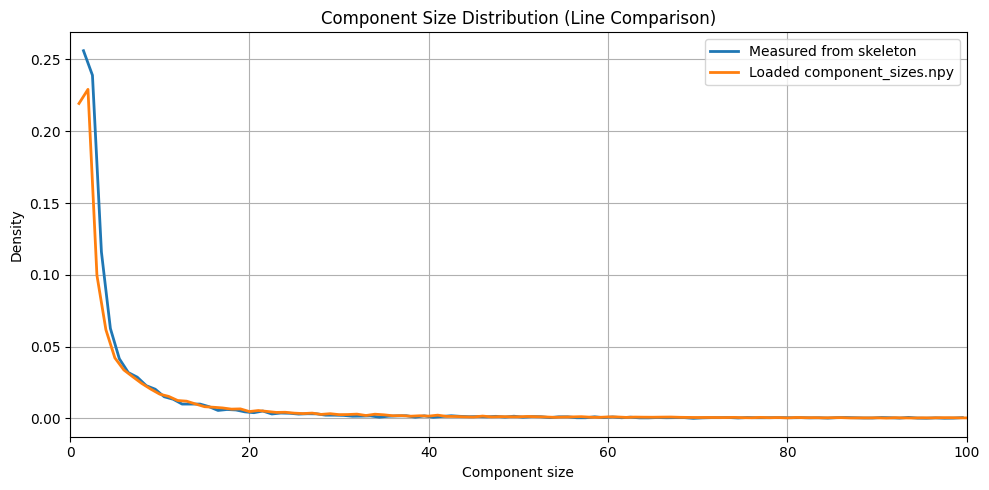

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label

# Load empirical component size distribution
loaded_data = np.load("component_sizes.npy")
unique_sizes, counts = loaded_data[:, 0], loaded_data[:, 1]
normalized_counts = counts / counts.sum()

# Label connected components in skeleton
structure = np.ones((3, 3, 3))
labeled, num = label(skeleton_data, structure=structure)

# Measure sizes using bincount
component_sizes = np.bincount(labeled.ravel())
measured_sizes = component_sizes[1:]  # skip background

# Compute histogram (same binning as loaded)
bins = np.arange(1, 101)  # 1 to 100 inclusive
hist_measured, _ = np.histogram(measured_sizes, bins=bins, density=True)

# Compute bin centers for plotting
bin_centers = (bins[:-1] + bins[1:]) / 2

# Filter loaded data to size ≤ 100
mask = unique_sizes <= 100
unique_filtered = unique_sizes[mask]
counts_filtered = normalized_counts[mask]

# Plot as lines
plt.figure(figsize=(10, 5))
plt.plot(bin_centers, hist_measured, label='Measured from skeleton', linewidth=2)
plt.plot(unique_filtered, counts_filtered, label='Loaded component_sizes.npy', linewidth=2)

plt.xlabel("Component size")
plt.ylabel("Density")
plt.title("Component Size Distribution (Line Comparison)")
plt.xlim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


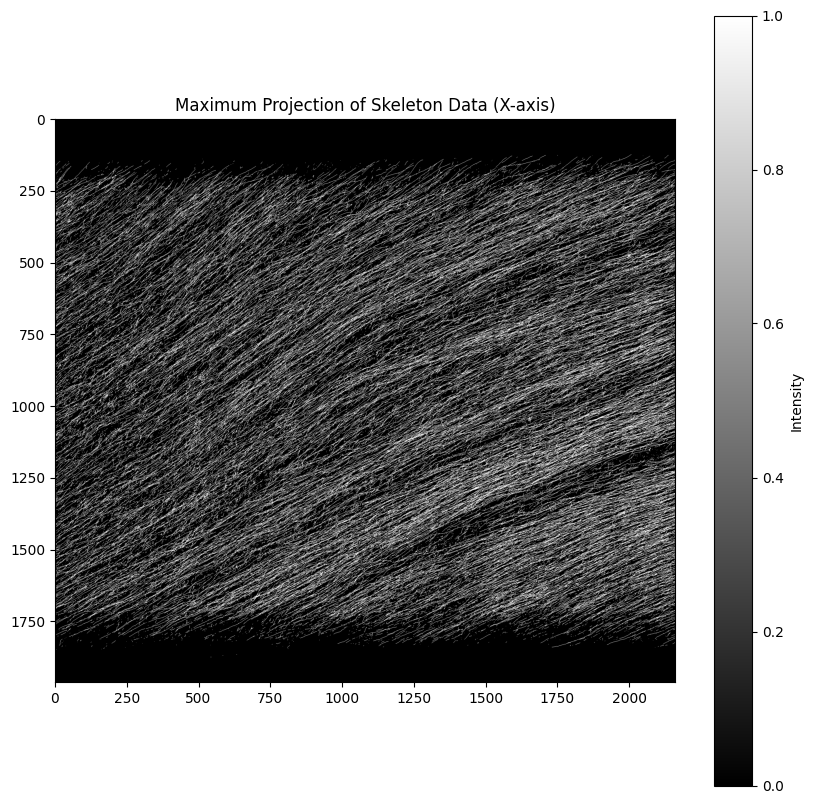

In [136]:
import nibabel as nib
import matplotlib.pyplot as plt

nii_file = "broken_segmentation.nii"
data = nib.load(nii_file)

# Convert the entire data to a numpy array
#data_array = np.array(data.dataobj)
# Extract a chunk of the data of size 500x500x500 directly from the NIfTI file
s_index = 800
data_array = np.array(data.dataobj[s_index:s_index+250, :,:])

bin_data_array = np.where(data_array > 0, 1, 0).astype(np.uint8)
skel_data_array = skeletonize(bin_data_array)

# Compute the maximum projection along the x-axis
max_projection = skel_data_array.max(axis=0)

# Plot the 2D image
plt.figure(figsize=(10, 10))
plt.imshow(max_projection, cmap='gray')
plt.title('Maximum Projection of Skeleton Data (X-axis)')
plt.colorbar(label='Intensity')
plt.show()

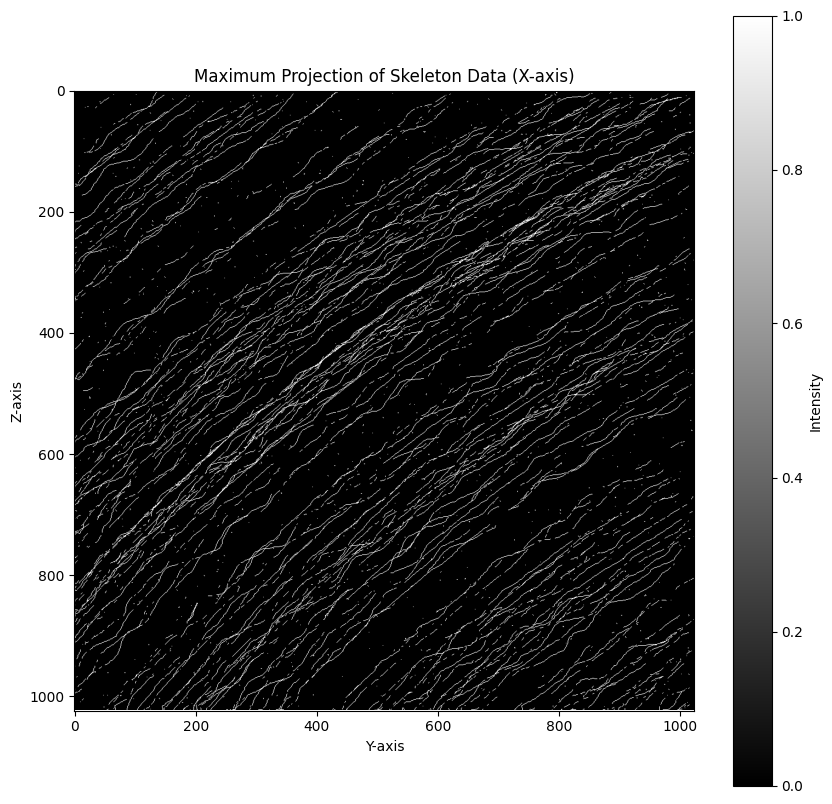

In [137]:
import matplotlib.pyplot as plt

# Compute the maximum projection along the x-axis
max_projection_sd = skeleton_data.max(axis=0)

# Plot the 2D image
plt.figure(figsize=(10, 10))
plt.imshow(max_projection_sd, cmap='gray')
plt.title('Maximum Projection of Skeleton Data (X-axis)')
plt.colorbar(label='Intensity')
plt.xlabel('Y-axis')
plt.ylabel('Z-axis')
plt.show()

In [31]:

# napari plot
import napari
viewer = napari.Viewer()
# Define a function to crop the data
def crop_data(data, start, size):
    return data[start[0]:start[0]+size[0], start[1]:start[1]+size[1], start[2]:start[2]+size[2]]

# Define the crop parameters
# start = (100, 100, 100)  # Starting point of the crop
# size = (32, 64, 64)  # Size of the crop
start = (0, 0, 0)  # Starting point of the crop
size = (64, shape[1], shape[2])  # Size of the crop

# Crop the data
cropped_skeleton_data = crop_data(skeleton_data, start, size)
cropped_skeleton_data_holes = crop_data(broken_skeleton, start, size)
# cropped_bin_data_array = crop_data(bin_data_array,start,size) 
# cropped_skel_data_array = crop_data(skel_data_array, start, size)


# Add the cropped data to the viewer
viewer.add_image(cropped_skeleton_data.astype(np.float32), name='skeleton_data', colormap='green')
viewer.add_image(cropped_skeleton_data_holes.astype(np.float32), name='broken_skeleton', colormap='red')
# viewer.add_image(cropped_skel_data_array.astype(np.float32), name='narwhal', colormap='cyan')
# viewer.add_image(cropped_bin_data_array.astype(np.float32), name='bin_data', colormap='blue')

print(np.sum(cropped_skeleton_data))
# print(np.sum(cropped_skel_data_array))
# print(np.sum(cropped_skeleton_data)/np.sum(cropped_skel_data_array))


118133


Number of features in skeleton: 3856
Number of features in skel: 3873
Ratio: 0.9956106377485153


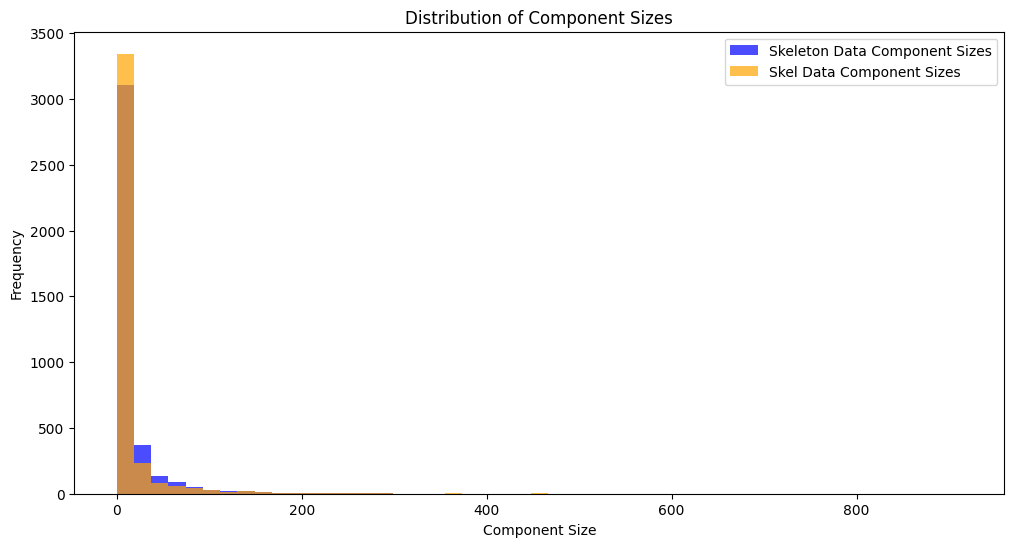

CoreSVG has logged an error. Set environment variabe "CORESVG_VERBOSE" to learn more.


In [141]:
# Label cropped_skeleton_data and cropped_skel_data_array to get the number of components
labeled_skeleton, num_features = label(cropped_skeleton_data, structure=np.ones((3, 3, 3)))
labeled_skel, num_features_skel = label(cropped_skel_data_array, structure=np.ones((3, 3, 3)))

# Print the number of features
print(f"Number of features in skeleton: {num_features}")
print(f"Number of features in skel: {num_features_skel}")
print(f"Ratio: {num_features / num_features_skel}")

# Compute the size of each component
sizes_skeleton = np.bincount(labeled_skeleton.ravel())[1:]  # Exclude background (label 0)
sizes_skel = np.bincount(labeled_skel.ravel())[1:]  # Exclude background (label 0)

# Determine the maximum size for binning
max_size = max(sizes_skeleton.max(), sizes_skel.max())

# Create bins with the same resolution for both histograms
bins = np.linspace(0, max_size, 50)

# Plot the sizes of components
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(sizes_skeleton, bins=bins, alpha=0.7, label='Skeleton Data Component Sizes', color='blue')
plt.hist(sizes_skel, bins=bins, alpha=0.7, label='Skel Data Component Sizes', color='orange')
plt.xlabel('Component Size')
plt.ylabel('Frequency')
plt.title('Distribution of Component Sizes')
plt.legend()
plt.show()



In [154]:
import scipy.ndimage

def structure_tensor(volume, sigma, rho):
    """ Structure tensor for 3D image data
    Arguments:
        volume: a 3D array of size N = slices(z)*rows(y)*columns(x)
        sigma: a noise scale, structures smaller than sigma will be 
            removed by smoothing
        rho: an integration scale giving the size over the neighborhood in 
            which the orientation is to be analysed
    Returns:
        an array with shape (6,N) containing elements of structure tensor 
            s_xx, s_yy, s_zz, s_xy, s_xz, s_yz ordered acording to 
            volume.ravel(). 
    Author: vand@dtu.dk, 2019
    """    # computing derivatives (scipy implementation truncates filter at 4 sigma)
    
    Vz = scipy.ndimage.gaussian_filter(volume, sigma, order=[0,0,1], mode='nearest')
    Vy = scipy.ndimage.gaussian_filter(volume, sigma, order=[0,1,0], mode='nearest')
    Vx = scipy.ndimage.gaussian_filter(volume, sigma, order=[1,0,0], mode='nearest')
    print (f"Vx shape: {Vx.shape}, Vy shape: {Vy.shape}, Vz shape: {Vz.shape}")
  
    # integrating elements of structure tensor (scipy uses sequence of 1D)
    Jxx = scipy.ndimage.gaussian_filter(Vx**2, rho, mode='nearest')
    Jyy = scipy.ndimage.gaussian_filter(Vy**2, rho, mode='nearest')
    Jzz = scipy.ndimage.gaussian_filter(Vz**2, rho, mode='nearest')
    Jxy = scipy.ndimage.gaussian_filter(Vx*Vy, rho, mode='nearest')
    Jxz = scipy.ndimage.gaussian_filter(Vx*Vz, rho, mode='nearest')
    Jyz = scipy.ndimage.gaussian_filter(Vy*Vz, rho, mode='nearest')
    S = np.vstack((Jxx.ravel(), Jyy.ravel(), Jzz.ravel(), Jxy.ravel(),\
                   Jxz.ravel(), Jyz.ravel()));
    return S

def eig_special(S, full=False):
    """ Eigensolution for symmetric real 3-by-3 matrices
    Arguments:
        S: an array with shape (6,N) containing structure tensor
        full: a flag indicating that all three eigenvalues should be returned
    Returns:
        val: an array with shape (3,N) containing sorted eigenvalues
        vec: an array with shape (3,N) containing eigenvector corresponding to 
            the smallest eigenvalue. If full, vec has shape (6,N) and contains 
            all three eigenvectors 
    More:        
        An analytic solution of eigenvalue problem for real symmetric matrix,
        using an affine transformation and a trigonometric solution of third
        order polynomial. See https://en.wikipedia.org/wiki/Eigenvalue_algorithm
        which refers to Smith's algorithm https://dl.acm.org/citation.cfm?id=366316
    Author: vand@dtu.dk, 2019
    """    
    # TODO -- deal with special cases, decide treatment of full (i.e. maybe return 2 for full)
    # computing eigenvalues
    s = S[3]**2 + S[4]**2 + S[5]**2 # off-diagonal elements
    q = (1/3)*(S[0]+S[1]+S[2]) # mean of on-diagonal elements
    p = np.sqrt((1/6)*(np.sum((S[0:3] - q)**2, axis=0) + 2*s)) # case p==0 treated below 
    p_inv = np.zeros(p.shape)
    p_inv[p!=0] = 1/p[p!=0] # to avoid division by 0
    B = p_inv * (S - np.outer(np.array([1,1,1,0,0,0]),q))  # B represents a 3-by-3 matrix, A = pB+2I   
    d = B[0]*B[1]*B[2] + 2*B[3]*B[4]*B[5] - B[3]**2*B[2]\
            - B[4]**2*B[1] - B[5]**2*B[0] # determinant of B
    phi = np.arccos(np.minimum(np.maximum(d/2,-1),1))/3 # min-max to ensure -1 <= d/2 <= 1 
    val = q + 2*p*np.cos(phi.reshape((1,-1))+np.array([[2*np.pi/3],[4*np.pi/3],[0]])) # ordered eigenvalues

    # computing eigenvectors -- either only one or all three
    if full:
        l = val
    else:
        l=val[0]
            
    u = S[4]*S[5]-(S[2]-l)*S[3]
    v = S[3]*S[5]-(S[1]-l)*S[4]
    w = S[3]*S[4]-(S[0]-l)*S[5]
    vec = np.vstack((u*v, u*w, v*w)) # contains one or three vectors
   
    # normalizing -- depends on number of vectors
    if full: # vec is [x1 x2 x3 y1 y2 y3 z1 z2 z3]
        vec = vec[[0,3,6,1,4,7,2,5,8]] # vec is [v1, v2, v3]
        l = np.sqrt(np.vstack((np.sum(vec[0:3]**2,axis=0), np.sum(vec[3:6]**2,\
                axis=0), np.sum(vec[6:]**2, axis=0))))
        vec = vec/l[[0,0,0,1,1,1,2,2,2]] # division by 0 should not occur
    else: # vec is [x1 y1 z1] = v1
        vec = vec/np.sqrt(np.sum(vec**2, axis=0))
    return val,vec


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def mean_axis(vecs):
    """
    Computes the mean axis from a set of 3D unit vectors, treating (v) and (-v) as the same direction.
    Now with error checks and zero-vector filtering.
    """
    norms = np.linalg.norm(vecs, axis=1, keepdims=True)
    valid_mask = (norms > 1e-6).flatten()
    vecs = vecs[valid_mask]

    if len(vecs) == 0:
        raise ValueError("All vectors have zero length. Cannot compute mean axis.")

    vecs = vecs / np.linalg.norm(vecs, axis=1, keepdims=True)
    orientation_matrix = np.einsum('ni,nj->ij', vecs, vecs)

    if not np.all(np.isfinite(orientation_matrix)):
        raise ValueError("Orientation matrix contains NaN or Inf.")

    eigvals, eigvecs = np.linalg.eigh(orientation_matrix)

    return eigvecs[:, np.argmax(eigvals)]

def align_vectors_to_mean(vectors, mean):
    """
    Align vectors to the same hemisphere as the mean vector.
    """
    vectors = np.array(vectors)
    mean = mean / np.linalg.norm(mean)
    dots = np.dot(vectors, mean)  # shape (N,)
    signs = np.where(dots < 0, -1, 1).reshape(-1, 1)
    aligned = vectors * signs
    aligned = aligned / np.linalg.norm(aligned, axis=1, keepdims=True)
    return aligned

def get_azimuth_altitude(volume, sigma=1, rho=3):
    # Compute structure tensor and dominant orientation
    S = structure_tensor(volume.astype(np.float32), sigma=sigma, rho=rho)
    _, vecs = eig_special(S)

    # Transpose vecs to shape (N, 3)
    vecs = vecs.T

    # Compute mean axis and align
    mean = mean_axis(vecs)
    vecs = align_vectors_to_mean(vecs, mean)

    # Extract direction components
    x, y, z = vecs[:, 0], vecs[:, 1], vecs[:, 2]

    # Convert to spherical coordinates
    azimuth = np.arctan2(y, x) % (2 * np.pi)
    altitude = np.arccos(z)  # zenith angle [0, π]

    return azimuth, altitude, vecs

# Compute for both volumes
az1, alt1, vecs1 = get_azimuth_altitude(cropped_skel_data_array > 0)
az2, alt2, vecs2 = get_azimuth_altitude(cropped_skeleton_data > 0)



Vx shape: (41, 1024, 1024), Vy shape: (41, 1024, 1024), Vz shape: (41, 1024, 1024)


KeyboardInterrupt: 

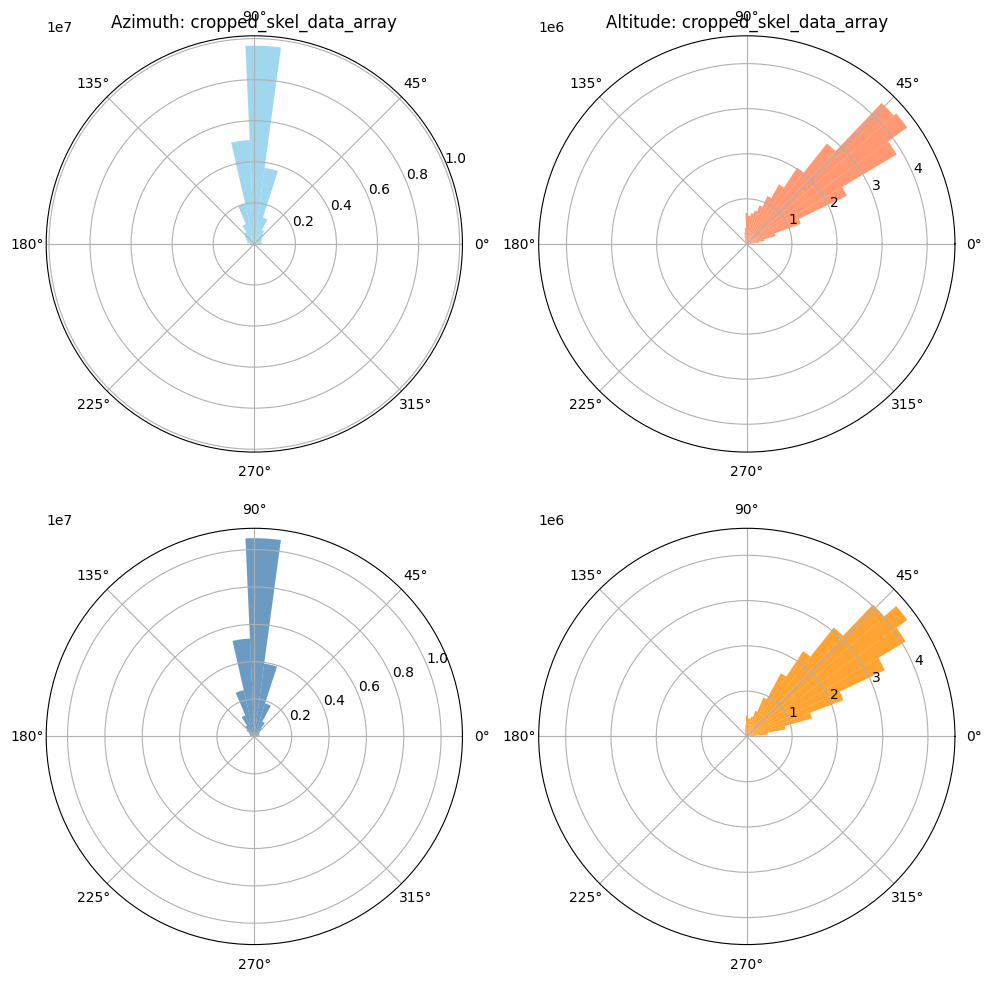

: 

In [ ]:

# Remove NaNs
az1, alt1 = az1[~np.isnan(az1)], alt1[~np.isnan(alt1)]
az2, alt2 = az2[~np.isnan(az2)], alt2[~np.isnan(alt2)]




# Plotting
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1, polar=True)
plt.title("Azimuth: cropped_skel_data_array")
plt.hist(az1-np.pi, bins=np.linspace(0, 2 * np.pi, 36), color='skyblue', alpha=0.8)

plt.subplot(2, 2, 2, polar=True)
plt.title("Altitude: cropped_skel_data_array")
plt.hist(alt1, bins=np.linspace(0, np.pi, 36), color='coral', alpha=0.8)

plt.subplot(2, 2, 3, polar=True)
# plt.title("Azimuth: cropped_skeleton_data")
plt.hist(az2-np.pi, bins=np.linspace(0, 2 * np.pi, 36), color='steelblue', alpha=0.8)

plt.subplot(2, 2, 4, polar=True)
# plt.title("Altitude: cropped_skeleton_data")
plt.hist(alt2, bins=np.linspace(0, np.pi, 36), color='darkorange', alpha=0.8)

plt.tight_layout()
plt.show()

In [125]:

def perm_test_angles(angles_A, angles_B, n_permutations=10000):
    """
    Permutation test for angular data. Compares the angular distance between
    the circular means of two sets of angles (in radians).
    """
    n_A = len(angles_A)
    n_B = len(angles_B)

    # Compute circular means
    mean_A = np.angle(np.mean(np.exp(1j * angles_A))) % (2*np.pi)
    mean_B = np.angle(np.mean(np.exp(1j * angles_B))) % (2*np.pi)

    # Observed angular difference
    obs_diff = np.abs((mean_A - mean_B + np.pi) % (2*np.pi) - np.pi)

    # Permutation test
    pooled = np.concatenate([angles_A, angles_B])
    null_distribution = np.zeros(n_permutations)

    for i in range(n_permutations):
        permuted = np.random.permutation(pooled)
        perm_A = permuted[:n_A]
        perm_B = permuted[n_A:]

        mean_perm_A = np.angle(np.mean(np.exp(1j * perm_A))) % (2 * np.pi)
        mean_perm_B = np.angle(np.mean(np.exp(1j * perm_B))) % (2 * np.pi)

        diff = np.abs((mean_perm_A - mean_perm_B + np.pi) % (2*np.pi) - np.pi)
        null_distribution[i] = diff
        print (f"Permutation: {i}, d:{np.rad2deg(diff)} >o:{np.rad2deg(obs_diff)} ? { diff > obs_diff}")

    p_value = np.mean(null_distribution >= obs_diff)

    # print(f"🧪 Permutation Test (angles): {np.sum(null_distribution >= obs_diff)} / {n_permutations}")
    # print(f"Observed angular difference: {np.rad2deg(obs_diff):.2f}°")
    # print(f"P-value: {p_value:.4f}")

    return p_value

def angular_distance(vec1, vec2):
    """Compute the angular distance between two unit vectors."""
    dot_product = np.clip(np.dot(vec1, vec2), -1.0, 1.0)  # Clip to avoid numerical issues
    if dot_product < 0:
        dot_product = -dot_product
    return np.arccos(dot_product)  # Returns angle in radians


def cartesian_to_spherical(vectors):
    vectors = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)
    x, y, z = vectors[:, 0], vectors[:, 1], vectors[:, 2]

    azimuth = np.arctan2(y, x)
    azimuth = np.mod(azimuth, 2*np.pi)

    altitude = np.arcsin(z)
    altitude = np.mod(altitude, 2*np.pi)

    return azimuth, altitude

In [135]:
def mean_axis(vecs):
    """
    Computes the mean axis from a set of 3D unit vectors, treating (v) and (-v) as the same direction.
    Includes validation and error handling.
    """
    vecs = np.asarray(vecs)

    # Remove rows with NaNs
    vecs = vecs[~np.isnan(vecs).any(axis=1)]

    if vecs.shape[0] == 0:
        raise ValueError("No valid vectors remain after removing NaNs.")

    # Normalize each vector
    norms = np.linalg.norm(vecs, axis=1, keepdims=True)
    valid = norms[:, 0] > 1e-6
    vecs = vecs[valid] / norms[valid]

    if vecs.shape[0] == 0:
        raise ValueError("All vectors have zero norm.")

    # Orientation matrix and eigenvector
    orientation_matrix = np.einsum('ni,nj->ij', vecs, vecs)

    if not np.all(np.isfinite(orientation_matrix)):
        raise ValueError("Orientation matrix contains NaN or Inf.")

    eigvals, eigvecs = np.linalg.eigh(orientation_matrix)

    return eigvecs[:, np.argmax(eigvals)]



# print ("Doing permutation test for azimuth")
print(az1.shape)
# Select random 1000 indices for azimuth and altitude
# Remove nan from az1 and alt1 and az2 and alt2
az1 = az1[~np.isnan(az1)]
alt1 = alt1[~np.isnan(alt1)]
az2 = az2[~np.isnan(az2)]
alt2 = alt2[~np.isnan(alt2)]
random_indices_az = np.random.choice(len(az1), 1000, replace=False)
random_indices_alt = np.random.choice(len(alt1), 1000, replace=False)

# Get difference in mean of azimuth and altitude angles using mean_axis
mean_az1 = mean_axis(vecs1[random_indices_az])
mean_az2 = mean_axis(vecs2[random_indices_az])
mean_alt1 = mean_axis(vecs1[random_indices_alt])
mean_alt2 = mean_axis(vecs2[random_indices_alt])

print (f"Mean azimuth 1: {mean_az1}")
print (f"Mean azimuth 2: {mean_az2}")
print (f"Mean altitude 1: {mean_alt1}")
print (f"Mean altitude 2: {mean_alt2}")

# Compute the angular distance between the two means
azimuth_diff = angular_distance(mean_az1, mean_az2)
altitude_diff = angular_distance(mean_alt1, mean_alt2)

print (f"Azimuth difference: {np.rad2deg(azimuth_diff)}")
print (f"Altitude difference: {np.rad2deg(altitude_diff)}")


# Perform permutation tests on randomly selected indices
p_az = perm_test_angles(az1[random_indices_az], az2[random_indices_az])
p_alt = perm_test_angles(alt1[random_indices_alt], alt2[random_indices_alt])

print (f"Azimuth p-value: {p_az}")
print (f"Altitude p-value: {p_alt}")

(15756005,)
Mean azimuth 1: [-0.77763838  0.62784823 -0.03294163]
Mean azimuth 2: [-0.80275061  0.59627488  0.00690792]
Mean altitude 1: [-0.8024332   0.59548194 -0.03875858]
Mean altitude 2: [-0.7979155   0.60274854 -0.0050048 ]
Azimuth difference: 3.2494080552794817
Altitude difference: 1.9952205866718644
Permutation: 0, d:1.045522974315309 >o:1.0954233869216028 ? False
Permutation: 1, d:1.446652127210284 >o:1.0954233869216028 ? True
Permutation: 2, d:1.2319250162157434 >o:1.0954233869216028 ? True
Permutation: 3, d:0.10505114834304657 >o:1.0954233869216028 ? False
Permutation: 4, d:0.19942242306712177 >o:1.0954233869216028 ? False
Permutation: 5, d:1.0837018865882555 >o:1.0954233869216028 ? False
Permutation: 6, d:0.6804979018792195 >o:1.0954233869216028 ? False
Permutation: 7, d:3.549518696318211 >o:1.0954233869216028 ? True
Permutation: 8, d:0.8589893566193321 >o:1.0954233869216028 ? False
Permutation: 9, d:0.7653193878936732 >o:1.0954233869216028 ? False
Permutation: 10, d:0.1292

# Other code

In [3]:
# Generate skeleton-based artificial data
shape = (256, 256, 256)
gap_threshold = 10
gap_chance = 0.3
num_lines = 5
skeleton_data, broken_skeleton, long_holes = generate_skeleton_with_thickness(shape, gap_threshold, gap_chance=gap_chance, num_lines=num_lines)
# skeleton_data, broken_skeleton, skeleton_data_og, hole_addtion = generate_skeleton_with_thickness()
#skeletonized_broken_skeleton = skeletonize(broken_skeleton[0])/255
print ("skeleton_data shape",skeleton_data.shape)

print ("skeleton_data type",skeleton_data.dtype)
print ("broken_skeleton type",broken_skeleton.dtype)
# print min max
print ("skeleton_data min max",np.min(skeleton_data),np.max(skeleton_data))
print ("broken_skeleton min max",np.min(broken_skeleton),np.max(broken_skeleton))

# print(ndimage.label(broken_skeleton[0])[1])

# Get subset that is from 32 to 1024+32
subset_broken_skeleton = broken_skeleton#[0][32:1024+32, 32:1024+32, 32:1024+32]
subset_skeleton_data = skeleton_data#[0][32:1024+32, 32:1024+32, 32:1024+32]
subset_long_holes = long_holes#[0][32:1024+32, 32:1024+32, 32:1024+32]

skeleton_data shape (256, 256, 256)
skeleton_data type uint8
broken_skeleton type uint8
skeleton_data min max 0 1
broken_skeleton min max 0 1


In [11]:

# napari plot
import napari
viewer = napari.Viewer()
# Define a function to crop the data
def crop_data(data, start, size):
    return data[start[0]:start[0]+size[0], start[1]:start[1]+size[1], start[2]:start[2]+size[2]]

# Define the crop parameters
# start = (100, 100, 100)  # Starting point of the crop
# size = (32, 64, 64)  # Size of the crop
start = (0, 0, 0)  # Starting point of the crop
size = (32, shape[1], shape[2])  # Size of the crop

# Crop the data
cropped_skeleton_data = crop_data(subset_skeleton_data, start, size)
cropped_broken_skeleton = crop_data(subset_broken_skeleton, start, size)
cropped_long_holes = crop_data(subset_long_holes, start, size)

cropped_skeleton_data = cropped_skeleton_data + cropped_broken_skeleton# + cropped_long_holes
# Normalize the data to [0, 1]
cropped_skeleton_data = (cropped_skeleton_data > 0).astype(np.float32)

# Add the cropped data to the viewer
viewer.add_image(cropped_skeleton_data.astype(np.float32), name='skeleton_data')
viewer.add_image(cropped_broken_skeleton.astype(np.float32), name='broken_skeleton', colormap='green')
viewer.add_image(cropped_long_holes.astype(np.float32), name='long_holes', colormap='red')


<Image layer 'long_holes' at 0x31ac49c60>

In [6]:
# save subset_broken_skeleton and subset_skeleton_data to npy files
np.save("1024_broken_skeleton_only.npy", subset_broken_skeleton)
np.save("1024_skeleton_only.npy", subset_skeleton_data)

In [4]:
import numpy as np
from noise import pnoise1

# Number of points (like length of a skeleton)
num_points = 500

# Noise settings
noise_scale = 0.02  # Lower = smoother changes
min_radius = 2
max_radius = 8

# Generate radius values over indices
radii = []
for i in range(num_points):
    noise_val = pnoise1(i * noise_scale)
    t = (noise_val + 1) / 2  # Normalize from [-1, 1] to [0, 1]
    radius = int(min_radius + t * (max_radius - min_radius))
    radius = max(1, radius)
    radii.append(radius)
    

# Print the radius values
print(radii)


[5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

In [3]:
# directory = "skeleton_data_output"
# image_path = os.path.join(directory, "skeleton_data_1024.npy")
# label_path = os.path.join(directory, "broken_skeleton_1024.npy")

# skeleton_data = np.load(image_path)[0]  # Load full 3D image as int8
# broken_skeleton = np.load(label_path)[0]  # Load full 3D label as int8



In [5]:
skeleton_data_0 = skeleton_data[0].astype(np.int8)
broken_skeleton_0 = broken_skeleton[0].astype(np.int8)


In [ ]:
skeleton_data_og_0 = skeleton_data_og[0].astype(np.int8)
hole_addtion_0 = hole_addtion[0].astype(np.int8)

In [19]:
# print stats
print("Skeleton data shape:", skeleton_data.shape)
print("Broken skeleton shape:", broken_skeleton.shape)

#print uniques and their counts:
broken_skeleton_unique, broken_skeleton_counts = np.unique(broken_skeleton, return_counts=True)
skeleton_data_unique, skeleton_data_counts = np.unique(skeleton_data, return_counts=True)

print("Unique values in broken skeleton:", broken_skeleton_unique, "Counts:", broken_skeleton_counts)
print("Unique values in skeleton data:", skeleton_data_unique, "Counts:", skeleton_data_counts)


size_of_view = 128 




Skeleton data shape: (1, 64, 64, 64)
Broken skeleton shape: (1, 64, 64, 64)
Unique values in broken skeleton: [0 1] Counts: [262109     35]
Unique values in skeleton data: [False  True] Counts: [260591   1553]


In [7]:

# Show with napari
import napari
viewer = napari.Viewer(ndisplay=3)

size_of_view = 512
start_point = (0, 0, 0)

view_skel = skeleton_data_0[start_point[0]:start_point[0]+size_of_view, start_point[1]:start_point[1]+size_of_view, start_point[2]:start_point[2]+size_of_view]
view_brok = broken_skeleton_0[start_point[0]:start_point[0]+size_of_view, start_point[1]:start_point[1]+size_of_view, start_point[2]:start_point[2]+size_of_view]

viewer.add_image(view_skel, colormap='gray', name='Skeleton Data')
viewer.add_image(view_brok, colormap='red', name='Broken Skeleton Data')

# # view_og = skeleton_data_og_0[start_point[0]:start_point[0]+size_of_view, start_point[1]:start_point[1]+size_of_view, start_point[2]:start_point[2]+size_of_view]
# # viewer.add_image(view_og, colormap='magenta', name='Skeleton Data Original', visible=False)

# # view_close_by_dilation = hole_addtion_0[start_point[0]:start_point[0]+size_of_view, start_point[1]:start_point[1]+size_of_view, start_point[2]:start_point[2]+size_of_view]
# # viewer.add_image(view_close_by_dilation, colormap='green', name='Hole addtion', visible=False)

# generator = ArtificialSkeletonGeneratorExtended(shape=view_brok.shape) # 0.000005 times shape^3

# time_start = time.time()
# view_brok = generator.remove_border_holes(view_brok)
# print (f"Time taken for removing border holes: {time.time()-time_start}")

# viewer.add_image(view_brok, colormap='red', name='Broken Skeleton Data', visible=False)




<Image layer 'Broken Skeleton Data' at 0x17e36cb80>

In [60]:

# Define the folder name
save_folder = "skeleton_data_output"

# Create the folder if it doesn't exist
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Save the generated data
np.save(os.path.join(save_folder, "skeleton_data_thick_what.npy"), skeleton_data) # Change what
np.save(os.path.join(save_folder, "broken_skeleton_thick_what.npy"), broken_skeleton)

In [86]:
import contextlib
import os
import sys
@contextlib.contextmanager
def suppress_prints():
    with open(os.devnull, 'w') as devnull:
        with contextlib.redirect_stdout(devnull), contextlib.redirect_stderr(devnull):
            yield

In [88]:
# Save multiple generated data
start_time = time.time()
number_of_data = 10

# Define the folder name
save_folder = "skeleton_data_output/thick/ver1"

# Create the folder if it doesn't exist
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

for i in range(number_of_data):
    print (f"Generating data for export: {i}, time: {time.time()-start_time}")
    # Generate skeleton-based artificial data
    with suppress_prints():
        skeleton_data, broken_skeleton = generate_skeleton_with_thickness()
    # Save the generated data
    np.save(os.path.join(save_folder, f"skeleton_data_thick_512_{i}.npy"), skeleton_data)
    np.save(os.path.join(save_folder, f"broken_skeleton_thick_512_{i}.npy"), broken_skeleton)

Generating data for export: 0, time: 0.0005371570587158203
Generating data for export: 1, time: 22.64486598968506
Generating data for export: 2, time: 45.279552936553955
Generating data for export: 3, time: 68.04323720932007
Generating data for export: 4, time: 91.27873706817627
Generating data for export: 5, time: 114.38601422309875
Generating data for export: 6, time: 137.28482103347778
Generating data for export: 7, time: 160.16904401779175
Generating data for export: 8, time: 183.4294261932373
Generating data for export: 9, time: 206.1597490310669


In [3]:
### Test the skeleton data structure vs the broken skeleton data structure.
# Get the labels with ndimage.label
# Define the connectivity structure
connectivity = np.ones((3, 3, 3))

# Label the skeletons
labeled_skeleton, num_labels = ndimage.label(skeleton_data[0], structure=connectivity)
labeled_hole_skeleton, num_labels_hole = ndimage.label(skeletonized_broken_skeleton, structure=connectivity)

# Define the minimum length threshold
min_length = 3  # Replace x with your desired threshold

# Compute sizes of each labeled component
sizes_skeleton = np.bincount(labeled_skeleton.ravel())[1:]  # Ignore background label (0)
sizes_hole_skeleton = np.bincount(labeled_hole_skeleton.ravel())[1:]

# Find labels that meet the minimum length requirement
valid_labels_skeleton = np.where(sizes_skeleton >= min_length)[0] + 1  # Labels are 1-based
valid_labels_hole_skeleton = np.where(sizes_hole_skeleton >= min_length)[0] + 1

# Create filtered label maps
labeled_skeleton = np.where(np.isin(labeled_skeleton, valid_labels_skeleton), labeled_skeleton, 0)
labeled_hole_skeleton = np.where(np.isin(labeled_hole_skeleton, valid_labels_hole_skeleton), labeled_hole_skeleton, 0)

print("Number of labels in skeleton data:", num_labels)
print("Number of labels in broken skeleton data:", num_labels_hole)
# Count the number of unique labels, excluding background (0)
num_labels_filtered_skeleton = np.count_nonzero(np.unique(labeled_skeleton) > 0)
num_labels_filtered_hole_skeleton = np.count_nonzero(np.unique(labeled_hole_skeleton) > 0)

# Print the results
print(f"Number of labels after filtering (skeleton): {num_labels_filtered_skeleton}")
print(f"Number of labels after filtering (hole skeleton): {num_labels_filtered_hole_skeleton}")


# Go through each label skeleton and get the direction between each voxel. Add this direction to a list
# Do the same for the hole skeleton. Then compare the data as two distributions.

Number of labels in skeleton data: 3948
Number of labels in broken skeleton data: 1107
Number of labels after filtering (skeleton): 1989
Number of labels after filtering (hole skeleton): 1074


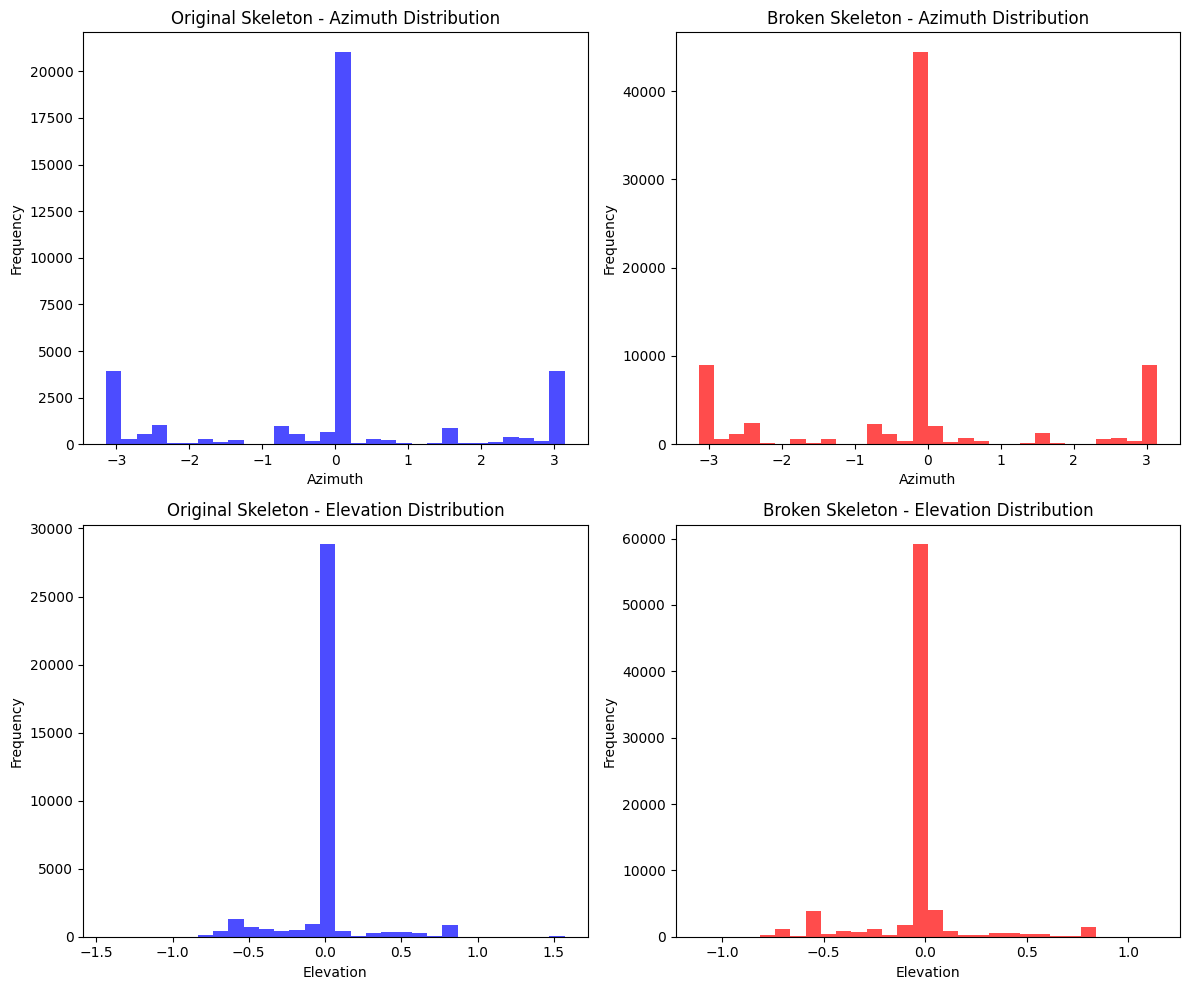

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

def compute_structure_tensor(skeleton):
    """
    Compute the structure tensor for the skeleton.
    
    :param skeleton: 3D skeleton binary image
    :return: List of dominant direction vectors at each voxel
    """
    # Compute gradients
    grad_x = ndimage.sobel(skeleton, axis=0)
    grad_y = ndimage.sobel(skeleton, axis=1)
    grad_z = ndimage.sobel(skeleton, axis=2)

    # Compute structure tensor components
    J_xx = grad_x * grad_x
    J_yy = grad_y * grad_y
    J_zz = grad_z * grad_z
    J_xy = grad_x * grad_y
    J_xz = grad_x * grad_z
    J_yz = grad_y * grad_z

    # Smooth to reduce noise
    J_xx = ndimage.gaussian_filter(J_xx, sigma=1)
    J_yy = ndimage.gaussian_filter(J_yy, sigma=1)
    J_zz = ndimage.gaussian_filter(J_zz, sigma=1)
    J_xy = ndimage.gaussian_filter(J_xy, sigma=1)
    J_xz = ndimage.gaussian_filter(J_xz, sigma=1)
    J_yz = ndimage.gaussian_filter(J_yz, sigma=1)

    # Compute eigenvectors of structure tensor
    directions = []
    for x, y, z in np.argwhere(skeleton):
        J = np.array([
            [J_xx[x, y, z], J_xy[x, y, z], J_xz[x, y, z]],
            [J_xy[x, y, z], J_yy[x, y, z], J_yz[x, y, z]],
            [J_xz[x, y, z], J_yz[x, y, z], J_zz[x, y, z]]
        ])
        eigvals, eigvecs = np.linalg.eigh(J)
        principal_direction = eigvecs[:, -1]  # Take the eigenvector with the largest eigenvalue
        directions.append(principal_direction)

    return np.array(directions)

def cartesian_to_spherical(directions):
    """
    Convert 3D direction vectors to spherical coordinates (azimuth, elevation).
    """
    azimuth = np.arctan2(directions[:,1], directions[:,0])  # XY-plane angle
    elevation = np.arcsin(directions[:,2])  # Z-axis angle
    return azimuth, elevation

def plot_histograms(directions1, directions2, bins=30):
    """
    Plot histograms of direction distributions in a single figure with 4 subplots.
    """
    azimuth1, elev1 = cartesian_to_spherical(directions1)
    azimuth2, elev2 = cartesian_to_spherical(directions2)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Plot Original Azimuth
    axes[0, 0].hist(azimuth1, bins=bins, alpha=0.7, color="blue")
    axes[0, 0].set_xlabel("Azimuth")
    axes[0, 0].set_ylabel("Frequency")
    axes[0, 0].set_title("Original Skeleton - Azimuth Distribution")

    # Plot Broken Azimuth
    axes[0, 1].hist(azimuth2, bins=bins, alpha=0.7, color="red")
    axes[0, 1].set_xlabel("Azimuth")
    axes[0, 1].set_ylabel("Frequency")
    axes[0, 1].set_title("Broken Skeleton - Azimuth Distribution")

    # Plot Original Elevation
    axes[1, 0].hist(elev1, bins=bins, alpha=0.7, color="blue")
    axes[1, 0].set_xlabel("Elevation")
    axes[1, 0].set_ylabel("Frequency")
    axes[1, 0].set_title("Original Skeleton - Elevation Distribution")

    # Plot Broken Elevation
    axes[1, 1].hist(elev2, bins=bins, alpha=0.7, color="red")
    axes[1, 1].set_xlabel("Elevation")
    axes[1, 1].set_ylabel("Frequency")
    axes[1, 1].set_title("Broken Skeleton - Elevation Distribution")

    plt.tight_layout()
    plt.show()



# Compute dominant directions using structure tensor
original_directions = compute_structure_tensor(labeled_skeleton)
hole_directions = compute_structure_tensor(labeled_hole_skeleton)

# Plot histograms
plot_histograms(original_directions, hole_directions)



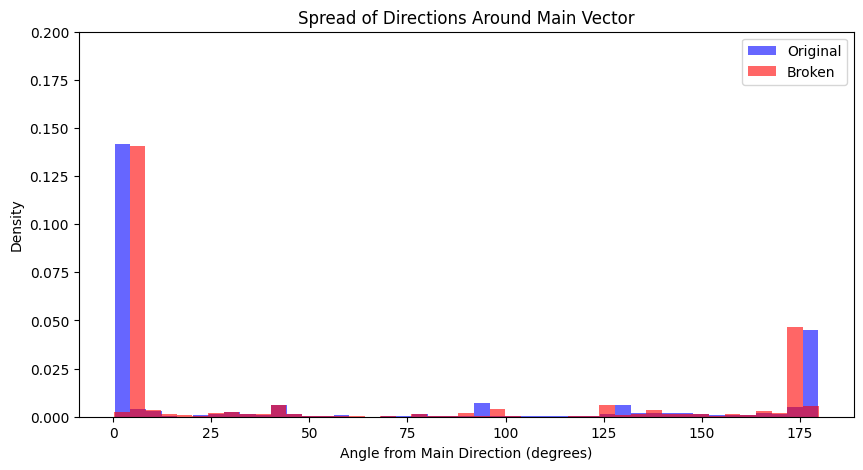

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def compute_main_vector(directions):
    """
    Compute the main direction vector by averaging all direction vectors.
    
    :param directions: (N,3) array of unit direction vectors
    :return: Normalized main direction vector (3,)
    """
    mean_vector = np.mean(directions, axis=0)  # Compute average direction
    return mean_vector / np.linalg.norm(mean_vector)  # Normalize

def compute_angle_spread(directions, main_vector):
    """
    Compute the angle deviation of each vector from the main direction vector.
    
    :param directions: (N,3) array of unit direction vectors
    :param main_vector: (3,) main direction vector
    :return: Array of angles (in degrees) between each vector and the main vector
    """
    dot_products = np.dot(directions, main_vector)  # Compute dot product
    angles = np.arccos(np.clip(dot_products, -1.0, 1.0))  # Compute angles (in radians)
    return np.degrees(angles)  # Convert to degrees for better interpretation

def plot_angle_spread(original_dirs, hole_dirs, bins=45):
    """
    Plot histograms of angle spreads for original and broken skeletons.
    
    :param original_dirs: (N,3) array of original unit direction vectors
    :param hole_dirs: (N,3) array of broken skeleton unit direction vectors
    """
    main_vector_orig = compute_main_vector(original_dirs)
    main_vector_hole = compute_main_vector(hole_dirs)

    angles_orig = compute_angle_spread(original_dirs, main_vector_orig)
    angles_hole = compute_angle_spread(hole_dirs, main_vector_hole)

    plt.figure(figsize=(10, 5))

    # Plot Original
    plt.hist(angles_orig, bins=bins, alpha=0.6, label="Original", color="blue", density=True)

    # Plot Broken
    plt.hist(angles_hole, bins=bins, alpha=0.6, label="Broken", color="red", density=True)

    plt.xlabel("Angle from Main Direction (degrees)")
    plt.ylabel("Density")
    plt.title("Spread of Directions Around Main Vector")
    plt.legend()
    plt.ylim(0, 0.2)  # Set the y-axis limit to a relevant value
    plt.show()

def align_directions(directions):
    """
    Ensure all direction vectors are consistently oriented.
    
    :param directions: (N,3) array of unit direction vectors
    :return: Aligned direction vectors
    """
    main_vector = np.mean(directions, axis=0)  # Compute the mean direction
    main_vector /= np.linalg.norm(main_vector)  # Normalize

    for i in range(len(directions)):
        if np.dot(directions[i], main_vector) < 0:  # If more than 90° off
            directions[i] *= -1  # Flip direction

    return directions

# Plot the corrected angle spread
plot_angle_spread(original_directions, hole_directions)

In [7]:

# Compute EMD similarity
angles_orig = compute_angle_spread(original_directions, compute_main_vector(original_directions))
angles_hole = compute_angle_spread(hole_directions, compute_main_vector(hole_directions))



In [8]:
print("Original Angles - Mean:", np.mean(angles_orig), "Std Dev:", np.std(angles_orig))
print("Broken Angles - Mean:", np.mean(angles_hole), "Std Dev:", np.std(angles_hole))
print("Original Angles - Min:", np.min(angles_orig), "Max:", np.max(angles_orig))
print("Broken Angles - Min:", np.min(angles_hole), "Max:", np.max(angles_hole))


Original Angles - Mean: 57.84035131406167 Std Dev: 72.67055032618957
Broken Angles - Mean: 59.865771925814634 Std Dev: 71.89693076622326
Original Angles - Min: 0.44043711960286797 Max: 179.72044281503202
Broken Angles - Min: 0.2309985066982622 Max: 179.73702154468359


In [10]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import ive  # Modified Bessel function (for vMF)

def normalize_vectors(vectors):
    """
    Normalize a set of 3D vectors to unit length.
    """
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / norms

# Convert angles to 3D unit vectors (Assuming angles_orig and angles_hole are in degrees)
def angles_to_unit_vectors(angles):
    """
    Convert angles into unit 3D vectors.
    Assumes angles are measured from a reference axis.
    """
    angles_rad = np.radians(angles)  # Convert to radians
    x = np.cos(angles_rad)  # X-axis component
    y = np.sin(angles_rad)  # Y-axis component
    z = np.zeros_like(angles_rad)  # No deviation in Z

    return np.column_stack((x, y, z))  # Shape (N,3)

# Convert angles to 3D unit vectors
vecs_orig = normalize_vectors(original_directions)
vecs_hole = normalize_vectors(hole_directions)


In [15]:
import numpy as np

# Assume vecs_orig and vecs_hole are already defined as large 3D unit vectors
n_orig = 1000  # Target group size after shuffling
n_hole = 1500  # Target group size after shuffling

# Compute observed test statistic: Norm of difference in mean vectors
obs_diff = np.linalg.norm(np.mean(vecs_orig, axis=0) - np.mean(vecs_hole, axis=0))

# Permutation test settings
n_permutations = 1000  # Reduce further if necessary
pooled = np.vstack([vecs_orig, vecs_hole])
n_total = pooled.shape[0]

# Precompute indices instead of shuffling large arrays
null_distribution = np.zeros(n_permutations)

for i in range(n_permutations):
    perm_indices = np.random.choice(n_total, n_orig + n_hole, replace=False)  # Random indices
    perm_group1 = pooled[perm_indices[:n_orig]]
    perm_group2 = pooled[perm_indices[n_orig:]]
    
    # Compute test statistic for permuted data
    null_distribution[i] = np.linalg.norm(np.mean(perm_group1, axis=0) - np.mean(perm_group2, axis=0))

# Compute p-value
p_value = np.mean(null_distribution >= obs_diff)

print(f"Observed Difference: {obs_diff}")
print(f"P-value: {p_value}")


Observed Difference: 0.020304307942801136
P-value: 0.655


In [17]:
print ("stats about data so far:")
print (skeleton_data.shape)
print (broken_skeleton.shape)
print (labeled_skeleton.shape)
print (labeled_hole_skeleton.shape)
print (original_directions.shape)
print (hole_directions.shape)
print (vecs_orig.shape)
print (vecs_hole.shape)

stats about data so far:
(1, 512, 512, 512)
(1, 512, 512, 512)
(512, 512, 512)
(512, 512, 512)
(36440, 3)
(78787, 3)
(36440, 3)
(78787, 3)


In [55]:
# print info about skeleton_data[0] and broken_skeleton[0]
print ("skeleton_data[0] info:")
print ("unique values: ", np.unique(skeleton_data[0]))
print ("shape: ", skeleton_data[0].shape)
print ("dtype: ", skeleton_data[0].dtype)
print ("max value: ", np.max(skeleton_data[0]))
print ("min value: ", np.min(skeleton_data[0]))
print ("sum: ", np.sum(skeleton_data[0]))

print ("broken_skeleton[0] info:")
print ("unique values: ", np.unique(broken_skeleton[0]))
print ("shape: ", broken_skeleton[0].shape)
print ("dtype: ", broken_skeleton[0].dtype)
print ("max value: ", np.max(broken_skeleton[0]))
print ("min value: ", np.min(broken_skeleton[0]))
print ("sum: ", np.sum(broken_skeleton[0]))


skeleton_data[0] info:
unique values:  [0. 1.]
shape:  (512, 512, 512)
dtype:  float32
max value:  1.0
min value:  0.0
sum:  39316.0
broken_skeleton[0] info:
unique values:  [False  True]
shape:  (512, 512, 512)
dtype:  bool
max value:  True
min value:  False
sum:  402337


In [ ]:
st_skeleton_data = compute_structure_tensor(skeleton_data[0])


In [56]:
st_hole_data = compute_structure_tensor(skeletonized_broken_skeleton)

In [58]:

def perm_test(vecs_orig, vecs_hole, n_orig, n_hole, n_permutations):

    # Compute observed test statistic: Norm of difference in mean vectors
    obs_diff = np.linalg.norm(np.mean(vecs_orig, axis=0) - np.mean(vecs_hole, axis=0))

    # Permutation test settings
    pooled = np.vstack([vecs_orig, vecs_hole])
    n_total = pooled.shape[0]

    # Precompute indices instead of shuffling large arrays
    null_distribution = np.zeros(n_permutations)

    for i in range(n_permutations):
        perm_indices = np.random.choice(n_total, n_orig + n_hole, replace=False)  # Random indices
        perm_group1 = pooled[perm_indices[:n_orig]]
        perm_group2 = pooled[perm_indices[n_orig:]]
        
        # Compute test statistic for permuted data
        null_distribution[i] = np.linalg.norm(np.mean(perm_group1, axis=0) - np.mean(perm_group2, axis=0))

    # Compute p-value
    p_value = np.mean(null_distribution >= obs_diff)

    return p_value

In [59]:
perm_test(st_skeleton_data, st_hole_data, 1000, 1000, 1000)

0.073

In [28]:
print (st_skeleton_data.shape)
print (st_hole_data.shape)
print (vecs_orig.shape)
print (vecs_hole.shape)
print (labeled_skeleton.shape)
print (labeled_hole_skeleton.shape)
# number of uniques in labeled_skeleton and labeled_hole_skeleton
print (len(np.unique(labeled_skeleton)))
print (len(np.unique(labeled_hole_skeleton)))

(39316, 3)
(402337, 3)
(36440, 3)
(78787, 3)
(512, 512, 512)
(512, 512, 512)
1990
1075


In [54]:
print (len(np.unique(st_hole_data)))

2


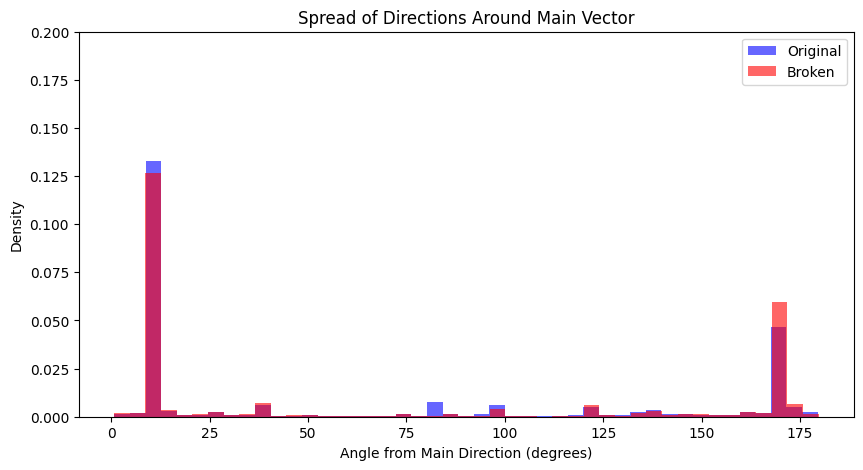

In [57]:
# plot the st_skeleton_data and st_hole_data
plot_angle_spread(st_skeleton_data, st_hole_data)



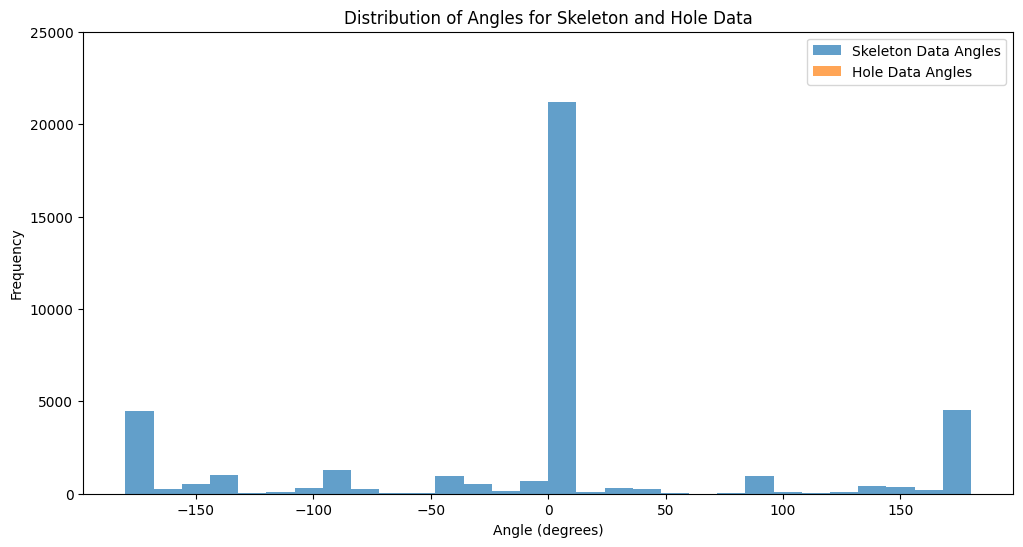

In [46]:
# Give me info about st_skeleton_data and st_hole_data
# for each entry that is in a 3d vector, find the angle of the first two elements. Do this for every entry and make a plot of the angles.
import matplotlib.pyplot as plt

def compute_angles(vectors):
    """
    Compute the angle of the first two elements of each 3D vector.
    
    :param vectors: (N,3) array of 3D vectors
    :return: Array of angles in degrees
    """
    angles = np.arctan2(vectors[:, 1], vectors[:, 0])  # Compute angles in radians
    return np.degrees(angles)  # Convert to degrees

# Compute angles for st_skeleton_data and st_hole_data
angles_skeleton = compute_angles(st_skeleton_data)
angles_hole = compute_angles(st_hole_data)

# Plot the angles
plt.figure(figsize=(12, 6))
plt.hist(angles_skeleton, bins=30, alpha=0.7, label='Skeleton Data Angles')
plt.hist(angles_hole, bins=30, alpha=0.7, label='Hole Data Angles')
plt.xlabel('Angle (degrees)')
plt.ylabel('Frequency')
plt.title('Distribution of Angles for Skeleton and Hole Data')
plt.legend()
plt.ylim(0, 25000)  # Set the y-axis limit to 25000
plt.show()
